In [1]:
import logging
import time
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch import cuda

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [4]:
import import_ipynb

from DCGAN import DCGAN ##### select DCGAN model
from utils import get_data_loader, generate_images, save_gif
import LeNet

importing Jupyter notebook from DCGAN_different_batch_normalization.ipynb


In [5]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [6]:
#hyperparameter settings
args = type('test', (object,), {})()
args.num_epochs = 5 #####10
args.ngpu = 1
args.ndf = 128
args.ngf = 128
args.nz = 100
args.lr = 0.0002
args.beta = 0.5
args.nc = 1
args.batch_size = 60 #####64
args.image_size = 64
args.num_test_samples = 64
args.output_path = "./results/"
args.fps = 5
args.use_fixed = True
args.plot = True

In [7]:
# Gather MNIST Dataset
transform=transforms.Compose([
                               transforms.Resize(args.image_size),
                               transforms.CenterCrop(args.image_size),
                               transforms.ToTensor(),
                            #    transforms.Normalize(mean=0.5, std=0.5)
                               transforms.Normalize(mean=(0.1307, ), std=(0.3081, )),
                           ])    
dataset = dset.MNIST(root='./mnist_data/',
                           transform=transform, download=True)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                                         shuffle=True)

In [8]:
# Device configuration
device = torch.device('cuda:0' if (torch.cuda.is_available() and args.ngpu > 0) else 'cpu')
print("Using", cuda.get_device_name(0))

Using NVIDIA GeForce RTX 3090


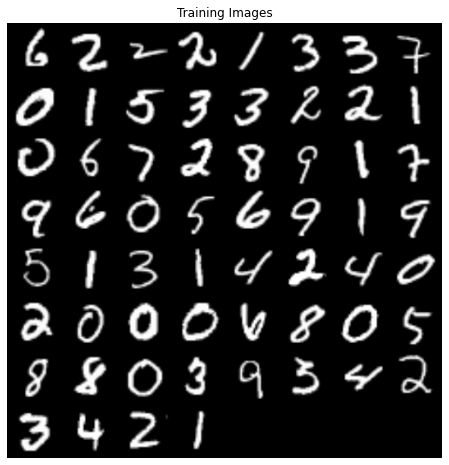

In [9]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# init dcgan
dcgan = DCGAN(ngpu=args.ngpu, device=device, lr=args.lr, nc=args.nc, ndf=args.ndf, nz=args.nz, ngf=args.ngf, beta1=args.beta)

In [11]:
# initialize other variables
num_batches = len(dataloader)
fixed_noise = torch.randn(args.num_test_samples, args.nz, 1, 1, device=device)

Starting Training Loop...
[0/5][0/1000]	Loss_D: 1.4935	Loss_G: 5.5556	D(x): 0.4574	D(G(z)): 0.4907 / 0.0041
[0/5][50/1000]	Loss_D: 0.0031	Loss_G: 8.1260	D(x): 0.9979	D(G(z)): 0.0009 / 0.0003
[0/5][100/1000]	Loss_D: 0.0015	Loss_G: 8.3440	D(x): 0.9994	D(G(z)): 0.0009 / 0.0002
[0/5][150/1000]	Loss_D: 0.0013	Loss_G: 9.0373	D(x): 0.9997	D(G(z)): 0.0010 / 0.0001
[0/5][200/1000]	Loss_D: 0.0013	Loss_G: 9.2153	D(x): 0.9994	D(G(z)): 0.0007 / 0.0001
[0/5][250/1000]	Loss_D: 0.0698	Loss_G: 5.3631	D(x): 0.9853	D(G(z)): 0.0521 / 0.0059
[0/5][300/1000]	Loss_D: 0.1974	Loss_G: 4.8465	D(x): 0.8564	D(G(z)): 0.0287 / 0.0091
[0/5][350/1000]	Loss_D: 0.0167	Loss_G: 6.5114	D(x): 0.9927	D(G(z)): 0.0093 / 0.0024
[0/5][400/1000]	Loss_D: 0.0033	Loss_G: 7.4512	D(x): 0.9980	D(G(z)): 0.0014 / 0.0008
[0/5][450/1000]	Loss_D: 0.0027	Loss_G: 7.1744	D(x): 0.9989	D(G(z)): 0.0016 / 0.0010
[0/5][500/1000]	Loss_D: 0.0028	Loss_G: 7.7181	D(x): 0.9979	D(G(z)): 0.0006 / 0.0005
[0/5][550/1000]	Loss_D: 0.0010	Loss_G: 8.2953	D(x): 0

[4/5][900/1000]	Loss_D: 0.0314	Loss_G: 4.8982	D(x): 0.9801	D(G(z)): 0.0087 / 0.0103
[4/5][950/1000]	Loss_D: 0.0170	Loss_G: 9.9835	D(x): 0.9840	D(G(z)): 0.0001 / 0.0002


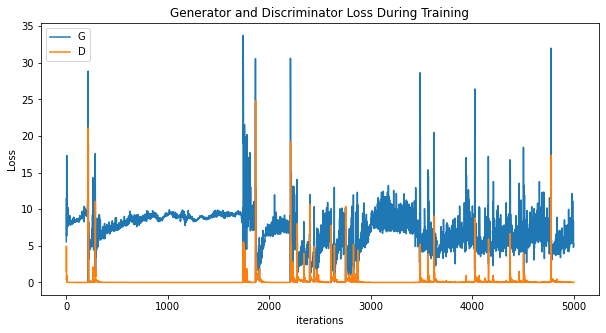

In [12]:
img_list = dcgan.train(dataloader=dataloader, num_epochs=args.num_epochs, plot=args.plot)

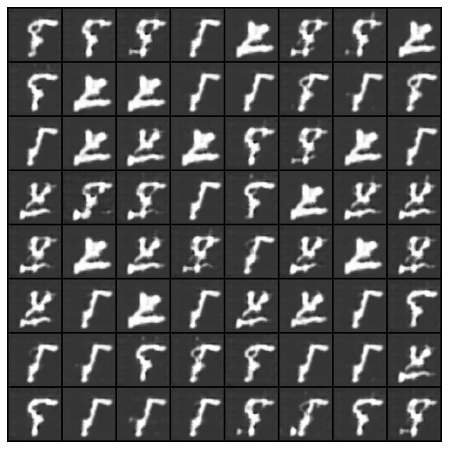

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
writergif = animation.PillowWriter(fps=30)
ani.save(args.output_path+"fake_dcgan.gif", writer=writergif)

In [14]:
#save model
model_path = "./models/"
filename = "dcgan_Q1.pt"
torch.save(dcgan, model_path+filename)

In [15]:
#load model
model_path = "./models/"
filename = "dcgan_Q1.pt"
dcgan = torch.load(model_path+filename)

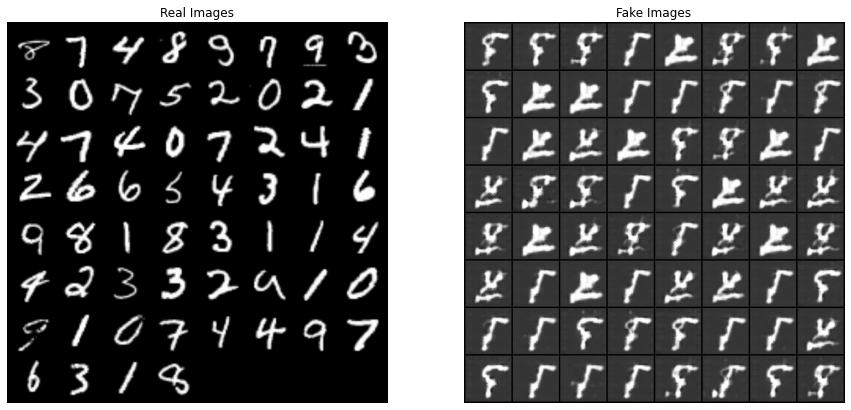

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()